# Dec ??th, 2021 (mat)

**Motivation**: temporal SNR Ca mat <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
mice = Mice((768, 4))
mice.setup_func_data('rest', bold_gsr=False)
mice.setup_preproc_data(bold_gsr=False)
mice.setup_anat_data()

In [5]:
def _load(mice, key, which: str = 'both'):
    if which == 'both':
        which = ['ca2', 'bold']
    else:
        which = [which]
    sub, ses, _ = mice.looper[key]
    
    if 'ca2' in which:
        m2d = mice.mask2d[mice.get_key(sub, ses)]
        m2d = m2d.load_ants().numpy().astype(bool)
        x2d = mice.ca_preproc[key][:]
        gs2d = x2d[m2d].mean(0)

        mu2d_abs = np.abs(x2d).mean(-1)
        mu2d = x2d.mean(-1)
        sd2d = x2d.std(-1)
        snr2d = mu2d / sd2d
        snr2d_avg = bn.nanmean(snr2d[m2d])
        out2d = {
            'm': m2d,
            'x': x2d,
            'gs': gs2d,
            'mu_abs': mu2d_abs,
            'mu': mu2d,
            'sd': sd2d,
            'snr': snr2d,
            'snr_avg': snr2d_avg,
        }
    else:
        out2d = None

    if 'bold' in which:
        m3d = mice.mask3d[mice.get_key(sub, ses)]
        m3d = m3d.load_ants().numpy().astype(bool)
        x3d = mice.bold_preproc[key][:]
        gs3d = x3d[m3d].mean(0)

        mu3d_abs = np.abs(x3d).mean(-1)
        mu3d = x3d.mean(-1)
        sd3d = x3d.std(-1)
        snr3d = mu3d / sd3d
        snr3d_avg = bn.nanmean(snr3d[m3d])

        out3d = {
            'm': m3d,
            'x': x3d,
            'gs': gs3d,
            'mu_abs': mu3d_abs,
            'mu': mu3d,
            'sd': sd3d,
            'snr': snr3d,
            'snr_avg': snr3d_avg,
        }
    else:
        out3d = None
        
    return out2d, out3d



def plot_2(out2d, key, threshold=0.05):
    xlist = [out2d['mu_abs'], out2d['mu'], out2d['sd'], out2d['snr'], out2d['m']]
    mu_abs, mu, sd, snr, m = filter_boundaries(xlist, out2d['m'])
    snr = np.abs(snr)
    
    fig1, axes = create_figure(1, 4, (13, 3.2), gridspec_kw={'width_ratios': [1, 1, 1, 1.5]})

    im = axes[0].imshow(mu_abs, cmap='Spectral')
    plt.colorbar(im, ax = axes[0], shrink=0.7)

    im = axes[1].imshow(mu, cmap='Spectral')
    plt.colorbar(im, ax = axes[1], shrink=0.7)

    im = axes[2].imshow(sd, cmap='Spectral')
    plt.colorbar(im, ax = axes[2], shrink=0.7)

    im = axes[3].imshow(snr, cmap='Spectral')
    plt.colorbar(im, ax = axes[3])

    axes[0].set_title(r'$\mu$ (abs)')
    axes[1].set_title(r'$\mu$')
    axes[2].set_title(r'$\sigma$')
    axes[3].set_title(r'tSNR $ = abs(\mu / \sigma)$')
    fig1.suptitle(f"plot #2, {key}", fontsize=14, y=1.02)
    remove_ticks(axes)
    plt.show()
    
    fig2, axes = create_figure(1, 2, (12, 2.7))

    vals = snr[np.logical_and(m, np.isfinite(snr))]
    vals = np.abs(vals)
    q = np.quantile(vals, threshold)
    sns.histplot(vals, ax=axes[0])
    axes[0].axvline(q, color='r', ls='--')
    axes[1].imshow(snr > q)
    remove_ticks(axes[1])
    plt.show()
    
    gs_good = out2d['x'][np.logical_and(out2d['m'], np.abs(out2d['snr']) > q)].mean(0)
    gs_bad = out2d['x'][np.logical_and(out2d['m'], np.abs(out2d['snr']) <= q)].mean(0)
    
    fig3, ax = create_figure(1, 1, (13, 4), sharex='all', sharey='all')
    ax.plot(gs_bad, color='r', lw=0.7, label='gs bad')
    ax.plot(gs_good, color='k', lw=0.9, label='gs good')
    ax.legend(fontsize='large')
    ax.grid()
    plt.show()
    
    return fig1, fig2, fig3

In [4]:
key = 'sub-SLC02_ses-1_run-1'
out2d, _ = _load(mice, key, 'ca2')

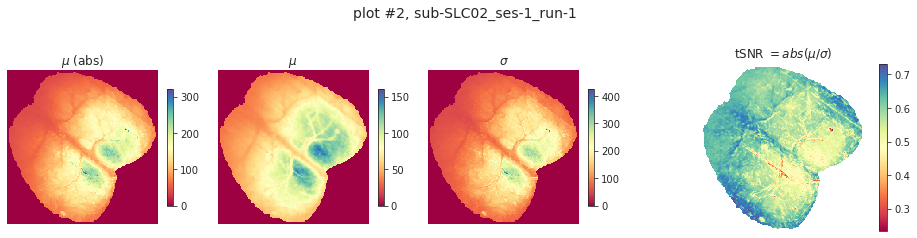

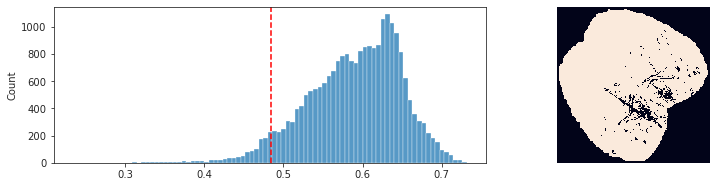

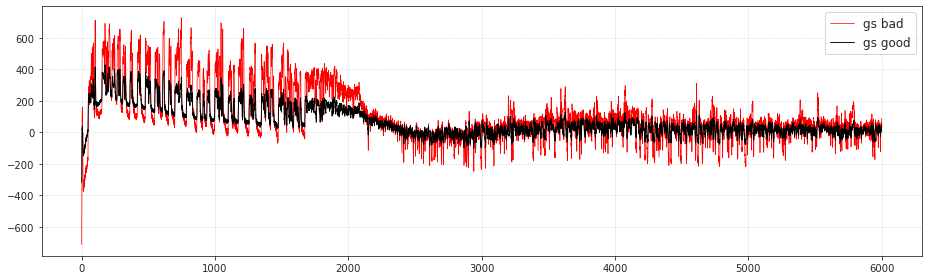

In [6]:
_ = plot_2(out2d, key)

In [11]:
threshold = 0.05

snr = np.abs(out2d['snr'])
vals = snr[np.logical_and(out2d['m'], np.isfinite(snr))]
vals = np.abs(vals)
q = np.quantile(vals, threshold)
q

0.484211857936571

<AxesSubplot:ylabel='Count'>

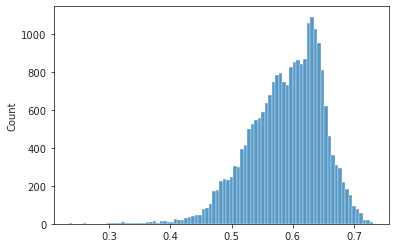

In [12]:
sns.histplot(vals)

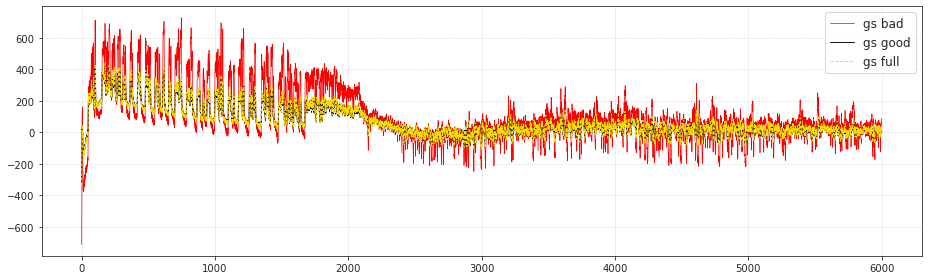

In [14]:
gs_full = out2d['x'][np.logical_and(out2d['m'], np.isfinite(snr))].mean(0)
gs_good = out2d['x'][np.logical_and(out2d['m'], np.abs(out2d['snr']) > q)].mean(0)
gs_bad = out2d['x'][np.logical_and(out2d['m'], np.abs(out2d['snr']) <= q)].mean(0)

fig3, ax = create_figure(1, 1, (13, 4), sharex='all', sharey='all')
ax.plot(gs_bad, color='r', lw=0.7, label='gs bad')
ax.plot(gs_good, color='k', lw=0.9, label='gs good')
ax.plot(gs_full, color='gold', lw=0.9, ls='--', label='gs full')
ax.legend(fontsize='large')
ax.grid()
plt.show()

[<matplotlib.lines.Line2D object at 0x7e29081262e0>]

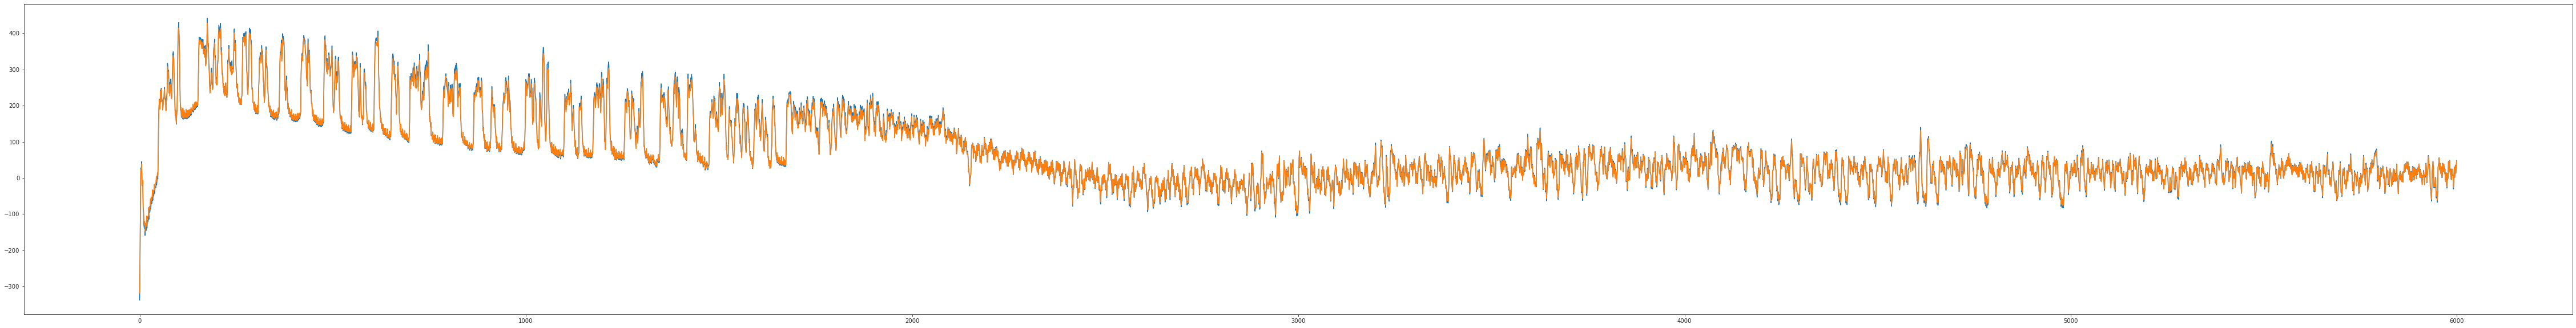

In [18]:
plt.figure(figsize=(80, 10))
plt.plot(gs_full)
plt.plot(gs_good)

In [20]:
import scipy

mdict = {'full': gs_full, 'good': gs_good, 'bad': gs_bad}
scipy.io.savemat(pjoin(tmp_dir, 'Ca-GS_02-1-1.mat'), mdict)

[<matplotlib.lines.Line2D object at 0x7e2908199c70>]

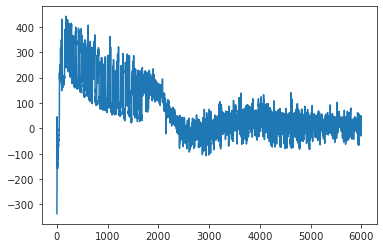

In [22]:
plt.plot(gs_full)

In [25]:
{k: sys.getsizeof(v) for k, v in mdict.items()}

{'full': 48104, 'good': 48104, 'bad': 48104}

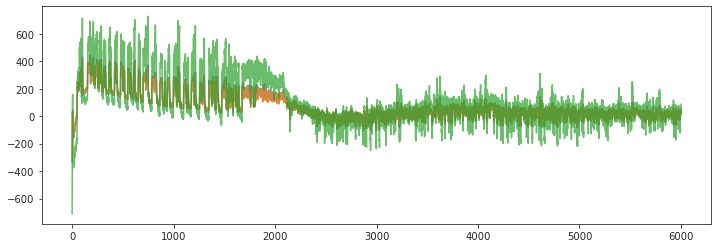

In [27]:
plt.figure(figsize=(12, 4))
for v in mdict.values():
    plt.plot(v, alpha=0.7)